Objective: Detect anomalies in the amount of data consumed over time by users accessing the Codeup curriculum pages. We want to know asap if it appears traffic to our site increases at an unexpected rate, as this could signify a security breach.

# Prepare Environment

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
# To format dates on our plots:
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

## User defined function to evaluate the models.

In [2]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

## User defined function to plot the models.

In [3]:
def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

# Wrangel Data
## Acquire

#### Label each field from the curriculum log.

In [4]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

#### Fabricate some anomalous observations for demonstration purposes.

In [5]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


#### Changes needed in data:

- timestamp: Remove square brackets, replace the first colon (after dd/MM/yyyy) with a space so we can then convert to datetime dtype, convert to datetime, set as index.
- request_method: Remove quotation marks and '?page=x', we may want to split request_method so the we have another columns with the request type (GET, PUT, ...). We'll wait and see if we want to use it.
- request_agent: Remove quotation marks.
- size: Convert to MB, purely to put the values in smaller number and units we are more accustomed to seeing.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Takeaways:

- The fact that destination is mostly null with a few non-nulls gives alert to possible anomalies.
- Convert timestamp to datetime.
- Once we remove destination, there will be no remaining missing values.

## Prep Data
#### Timestamp
- Remove square brackets.
- Replace the first colon (after dd/MM/yyyy) with a space so we can then convert to datetime dtype.
- Convert to datetime.

In [7]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 6 columns):
ip                13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(4)
memory usage: 764.4+ KB


#### Cleanup strings
- Remove quotation marks and '?page=x' from request_method.
- Remove quotation marks from request_agent.

In [9]:
df.destination.value_counts()

"https://python.zach.lol/"                                        4
"https://ds.codeup.com/8.3_Acquire/"                              3
"https://python.zach.lol/api/v1/stores?page=1"                    2
"https://python.zach.lol/api/v1/"                                 2
"https://python.zach.lol/api/v1//api/v1/items?page=2"             1
"https://python.zach.lol/api/v1/items"                            1
"https://python.zach.lol/api/v1//api/v1/items"                    1
"https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!"                1
"https://python.zach.lol/api/v1/sales?page=3"                     1
"https://python.zach.lol/api/v1/stores?page=0"                    1
"https://python.zach.lol/api/v1//api/v1/items/next_page"          1
"https://python.zach.lol/api/V1/HiZach!"                          1
"https://python.zach.lol/api/v1/stores?page=2"                    1
"http://localhost:8888/notebooks/acquire.ipynb"                   1
"http://localhost:8889/notebooks/timeseries_acqu

In [10]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [11]:
# Count how many unique request methods there are before cleaning
len(df.request_method.value_counts())

220

In [12]:
# Now clean the excess details out of the strings and recount.
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex = True)
len(df.request_method.value_counts())

22

Much better. We dropped from 220 to 22 request_method values.

Let's see how many of each value there are.

In [13]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/items/HTTP/1.1                          1
GET /api/v1 HTTP/1.1                                1
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1/I_DIDNT_DO_IT!!!

In [14]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


#### Use regex to extract each section of the request method into relevant new columns.

In [15]:
df[['request_call','api_version','endpoints','http']] = \
    df.request_method.str.extract(r'(?P<request_call>^[A-Z]+)\s(?P<api_version>\/api\/v[0-9])(?P<endpoints>.+)(?P<http_version>HTTP\/[0-9]\.[0-9])', expand = True)
df.head()

,ip,request_method,status,size,destination,request_agent,request_call,api_version,endpoints,http
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,GET,/api/v1,/items,HTTP/1.1
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1


We can see an anomaly in a few of the request_method strings. Looking at options: - Depending on our goal in this, these could be anomalies that can give us the answer we need, such as, is there a security breach?
- This column could simply be an extra independent or grouping variable, where anomalies are not significant and only get in the way of finding the anomalies we are interested in.
- The anomalies in this column could possibly be an indicator, when grouped with others, lead to higher likelihood of intruder. However, that may require research within the data. After that research you may decide that anomalies in this field are not important.
- In the cases where the data is most useful normalized or standardized, where anomalies only cause distractions, the goal would be to remove or normalize the anomaly.
- In the cases where the anomaly is what we would want to detect and look into further, keeping the anomalies, but maybe cleaning up the strings a bit to highlight where the differences occur.

In this case, the best action to take is the replace the /HTTP with , HTTP

In [16]:
print(df.endpoints.value_counts())

/sales                       12403
/items                        1065
/stores                        229
//api/v1/items                  11
/items/api/v1/items              7
/items/next_page                 5
/                                4
/itemsitems                      3
/sales/                          3
/store                           3
/sales/                          3
items                            2
/helloclass!                     1
/items&page=0                    1
//api/v1/items/next_page         1
/I_DIDNT_DO_IT!!!!               1
                                 1
/items/                          1
Name: endpoints, dtype: int64


What is entropy in machine learning?

Entropy, as it relates to machine learning, is a measure of the randomness in the information being processed. The higher the entropy, the harder it is to draw any conclusions from that information. Flipping a coin is an example of an action that provides information that is random.

In [17]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [18]:
compute_entropy(df.api_version)

0

In [19]:
compute_entropy(df.status)

0.0103058384931202

In [20]:
compute_entropy(df.request_call)

0

In [21]:
compute_entropy(df.ip)

0.5669620287409953

#### Size
Represent size in MB for ease of conceptual understanding.

In [22]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [23]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


1. Resample to 30 minute intervals taking max of size.
2. Fill in missing datetimestamps (those not present because no data was captured during that time. We want to have continuous time and those time periods filled with 0).

In [24]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').max()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

#### Split into train/test:

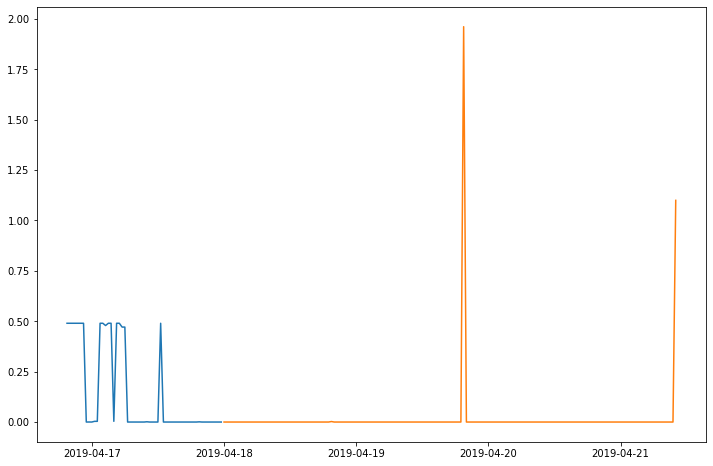

In [25]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:30:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

## Finding More Anomalies
### SMA - Simple Moving Average:

In [26]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()

short_rolling.head(13)

2019-04-16 19:30:00+00:00         NaN
2019-04-16 20:00:00+00:00         NaN
2019-04-16 20:30:00+00:00         NaN
2019-04-16 21:00:00+00:00         NaN
2019-04-16 21:30:00+00:00         NaN
2019-04-16 22:00:00+00:00         NaN
2019-04-16 22:30:00+00:00         NaN
2019-04-16 23:00:00+00:00         NaN
2019-04-16 23:30:00+00:00         NaN
2019-04-17 00:00:00+00:00         NaN
2019-04-17 00:30:00+00:00         NaN
2019-04-17 01:00:00+00:00    0.286391
2019-04-17 01:30:00+00:00    0.286391
Freq: 30T, Name: size_mb, dtype: float64

In [27]:
short_rolling[20:30]

2019-04-17 05:30:00+00:00    0.324983
2019-04-17 06:00:00+00:00    0.364235
2019-04-17 06:30:00+00:00    0.363944
2019-04-17 07:00:00+00:00    0.363653
2019-04-17 07:30:00+00:00    0.322825
2019-04-17 08:00:00+00:00    0.281997
2019-04-17 08:30:00+00:00    0.242107
2019-04-17 09:00:00+00:00    0.201279
2019-04-17 09:30:00+00:00    0.160451
2019-04-17 10:00:00+00:00    0.160266
Freq: 30T, Name: size_mb, dtype: float64

In [28]:
long_rolling[20:30]

2019-04-17 05:30:00+00:00         NaN
2019-04-17 06:00:00+00:00         NaN
2019-04-17 06:30:00+00:00         NaN
2019-04-17 07:00:00+00:00    0.325022
2019-04-17 07:30:00+00:00    0.304608
2019-04-17 08:00:00+00:00    0.284194
2019-04-17 08:30:00+00:00    0.263780
2019-04-17 09:00:00+00:00    0.243366
2019-04-17 09:30:00+00:00    0.222952
2019-04-17 10:00:00+00:00    0.202591
Freq: 30T, Name: size_mb, dtype: float64

### Plot the 2 window sizes for the SMA:

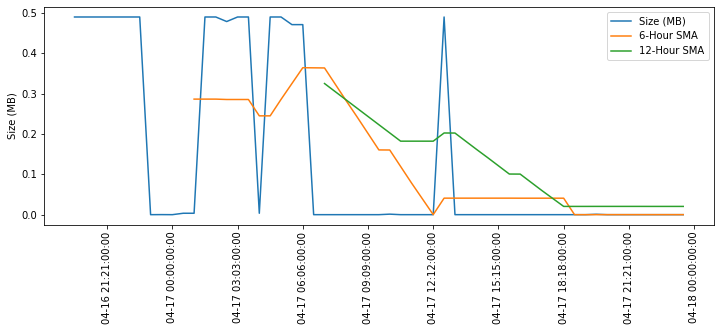

In [40]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
plt.xticks(rotation=90)
ax.xaxis.set_major_formatter(my_datetime_fmt)

### Using Bollinger Bands & %b to detect anomalies
We need: - Exponential Moving Average - Window span - Upper band - Lower band

#### Exponential Moving Average
SMA timeseries are much less noisy than the original price timeseries. However, this comes at a cost; SMA timeseries lag the original price timeseries, which means that changes in the trend are only seen with a delay (lag) of L time units (30 minute periods in this case).

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, whereas the SMA weights all observations equally by 1M.

- M = Number of time periods, span of the window
- $t_{0}$ = Latest value
- t −1 = Previous value
- $EMA_{t−1}$ = Exponential moving average of previous day.
- The multiplier: α = $\frac{2}{M+1}$
- $EMA_{t}$ = α ∗ ($t_{0}$ − $EMA_{t−1}$) + $EMA_{t−1}$

Example: - EMA = (currentday - $EMA_{previousday}$) * multiplier + $EMA_{previousday}$ - Initial SMA: 10-period sum / 10 - Multiplier: (2 / (Time periods + 1) ) = (2 / (10 + 1) ) = 0.1818 (18.18%)

In [41]:
train.tail()

2019-04-17 21:30:00+00:00    0.0
2019-04-17 22:00:00+00:00    0.0
2019-04-17 22:30:00+00:00    0.0
2019-04-17 23:00:00+00:00    0.0
2019-04-17 23:30:00+00:00    0.0
Freq: 30T, Name: size_mb, dtype: float64

In [42]:
short_rolling.tail()

2019-04-17 21:30:00+00:00    0.00008
2019-04-17 22:00:00+00:00    0.00008
2019-04-17 22:30:00+00:00    0.00008
2019-04-17 23:00:00+00:00    0.00008
2019-04-17 23:30:00+00:00    0.00008
Freq: 30T, Name: size_mb, dtype: float64

In [43]:
long_rolling.tail()

2019-04-17 21:30:00+00:00    0.020507
2019-04-17 22:00:00+00:00    0.020454
2019-04-17 22:30:00+00:00    0.020454
2019-04-17 23:00:00+00:00    0.020454
2019-04-17 23:30:00+00:00    0.020454
Freq: 30T, Name: size_mb, dtype: float64